   Status                                            Message
0  Normal  Go until jurong point, crazy.. Available only ...
1  Normal                   Ok lar... Joking wif u oni...   
2    spam  Free entry in 2 a wkly comp to win FA Cup fina...
3  Normal  U dun say so early hor... U c already then say...
4  Normal  Nah I don't think he goes to usf, he lives aro...
Status     0
Message    0
dtype: int64


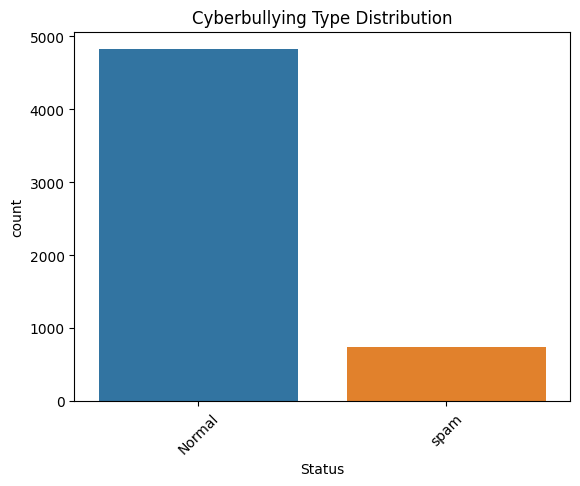

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV
df = pd.read_csv('spam.csv',encoding='ISO-8859-1')

# View first few rows
print(df.head())

# Check for null values
print(df.isnull().sum())

# Class distribution
sns.countplot(data=df, x='Status')
plt.title("Cyberbullying Type Distribution")
plt.xticks(rotation=45)
plt.show()


In [7]:
import re
import nltk
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

nltk.download('stopwords')

def clean_text(text):
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-zA-Z]", " ", text)
    text = text.lower()
    text = text.split()
    text = [word for word in text if word not in stopwords.words("english")]
    return " ".join(text)

df['cleaned_text'] = df['Message'].apply(clean_text)

# Tokenization
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(df['cleaned_text'])
sequences = tokenizer.texts_to_sequences(df['cleaned_text'])
X = pad_sequences(sequences, maxlen=100)

# Label Encoding
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(df['Status'])


[nltk_data] Downloading package stopwords to D:\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout

model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=128, input_length=100))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(64))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(len(set(y)), activation='softmax'))  # Multi-class classification

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 128)          640000    
                                                                 
 conv1d (Conv1D)             (None, 96, 64)            41024     
                                                                 
 max_pooling1d (MaxPooling1  (None, 48, 64)            0         
 D)                                                              
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                        

In [11]:
history = model.fit(X_train, y_train, epochs=6, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/6
140/140 [==============================] - 5s 35ms/step - loss: 3.6243e-05 - accuracy: 1.0000 - val_loss: 0.1151 - val_accuracy: 0.9857
Epoch 2/6
140/140 [==============================] - 4s 30ms/step - loss: 2.2497e-05 - accuracy: 1.0000 - val_loss: 0.1179 - val_accuracy: 0.9857
Epoch 3/6
140/140 [==============================] - 4s 31ms/step - loss: 1.8471e-05 - accuracy: 1.0000 - val_loss: 0.1203 - val_accuracy: 0.9857
Epoch 4/6
140/140 [==============================] - 4s 30ms/step - loss: 2.5720e-05 - accuracy: 1.0000 - val_loss: 0.1219 - val_accuracy: 0.9848
Epoch 5/6
140/140 [==============================] - 4s 31ms/step - loss: 1.0015e-05 - accuracy: 1.0000 - val_loss: 0.1240 - val_accuracy: 0.9857
Epoch 6/6
140/140 [==============================] - 5s 37ms/step - loss: 1.4851e-05 - accuracy: 1.0000 - val_loss: 0.1260 - val_accuracy: 0.9848


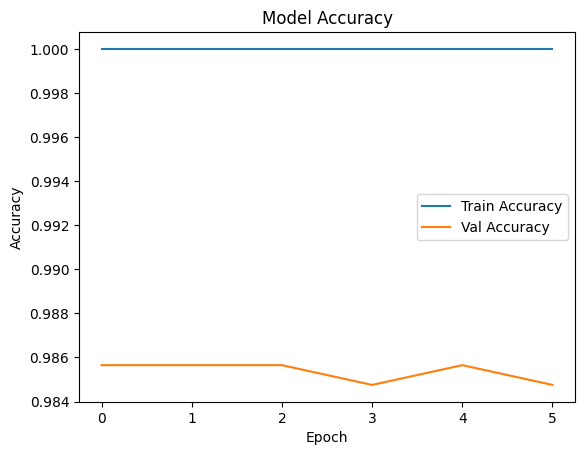

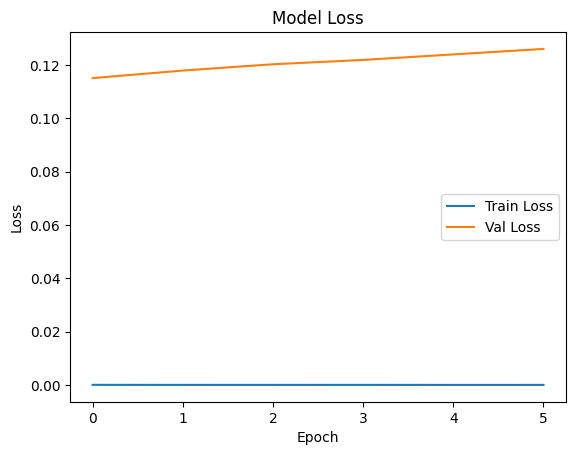

In [12]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [13]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
y_pred_labels = y_pred.argmax(axis=1)

print(classification_report(y_test, y_pred_labels, target_names=le.classes_))


35/35 [==============================] - 1s 9ms/step
              precision    recall  f1-score   support

      Normal       0.99      0.99      0.99       965
        spam       0.96      0.93      0.94       150

    accuracy                           0.98      1115
   macro avg       0.97      0.96      0.97      1115
weighted avg       0.98      0.98      0.98      1115



In [14]:
# Save the model
model.save("spam.h5")

# Save tokenizer and label encoder
import pickle

with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

with open("label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)


C:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [15]:
from tensorflow.keras.models import load_model
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load model
model = load_model("spam.h5")

# Load tokenizer and label encoder
with open("tokenizer.pkl", "rb") as f:
    tokenizer = pickle.load(f)

with open("label_encoder.pkl", "rb") as f:
    le = pickle.load(f)


In [16]:
def clean_text(text):
    import re
    import nltk
    nltk.download('stopwords')
    from nltk.corpus import stopwords
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"[^a-zA-Z]", " ", text)
    text = text.lower().split()
    text = [word for word in text if word not in stopwords.words("english")]
    return " ".join(text)

def predict_text(text):
    cleaned = clean_text(text)
    seq = tokenizer.texts_to_sequences([cleaned])
    padded = pad_sequences(seq, maxlen=100)
    pred = model.predict(padded)
    label = le.inverse_transform([pred.argmax(axis=1)[0]])
    return label[0]

# Example
sample_tweet = "rape is real..zvasiyana nema jokes about being drunk or being gay or being lesbian...rape is not ones choice or wish..thtz where the sensitivity is coming from"
print("Prediction:", predict_text(sample_tweet))


[nltk_data] Downloading package stopwords to D:\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


1/1 [==============================] - 0s 437ms/step
Prediction: Normal
